In [1]:
!pip install split-folders
import splitfolders
from google.colab import drive
drive.mount('/content/drive')
splitfolders.ratio("/content/drive/MyDrive/PhDProject/colon_image_sets",
            output="splitted_data",
            seed=42,
            ratio=(.7, .2, .1),
            group_prefix=None,
            move=False)

Mounted at /content/drive


Copying files: 10000 files [03:09, 52.74 files/s]


In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def fire_module(x, squeeze_channels, expand_channels):
    squeeze = Conv2D(squeeze_channels, (1, 1), activation='relu', padding='valid')(x)
    expand1x1 = Conv2D(expand_channels, (1, 1), activation='relu', padding='valid')(squeeze)
    expand3x3 = Conv2D(expand_channels, (3, 3), activation='relu', padding='same')(squeeze)
    return concatenate([expand1x1, expand3x3], axis=-1)

def SqueezeNet_1_1(input_shape, classes):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), strides=(2, 2), activation='relu', padding='valid')(input_tensor)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 32, 128)
    x = fire_module(x, 32, 128)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)
    x = fire_module(x, 64, 256)

    x = GlobalAveragePooling2D()(x)

    # Output layer
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=x)

    return model


# Print the model summary
#model.summary()


# Rest of the code remains unchanged


Found 7000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/15
219/219 [==============================] - 128s 565ms/step - loss: 0.6934 - accuracy: 0.4980 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/15
219/219 [==============================] - 121s 551ms/step - loss: 0.6933 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/15
219/219 [==============================] - 124s 564ms/step - loss: 0.6932 - accuracy: 0.4931 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/15
219/219 [==============================] - 123s 563ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/15
219/219 [==============================] - 121s 550ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/15
219/219 [==============================] - 123s 562ms/step - loss: 0.6932 - accuracy: 0.4983 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 7/15
219/219 [====================

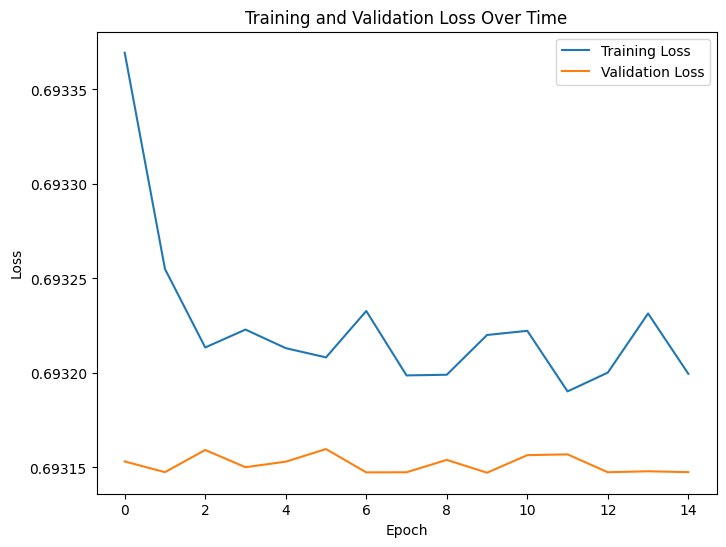

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming 'create_squeezenet_dilated_residual' function returns the model architecture
model = SqueezeNet_1_1(input_shape=(224, 224, 3), classes=2)
# Define the optimizer and loss function
optimizer = Adam()
loss_function = CategoricalCrossentropy()

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

# Data Preprocessing and Data Augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    "/content/splitted_data/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Data Preprocessing for validation data
val_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0
)

val_generator = val_datagen.flow_from_directory(
    "/content/splitted_data/val",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Training the model with validation data
epochs = 15
steps_per_epoch = len(train_generator)
validation_steps = len(val_generator)

try:
    history = model.fit(
        train_generator,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps
    )
except Exception as e:
    print("An error occurred during training:", str(e))

# Plot the training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.show()


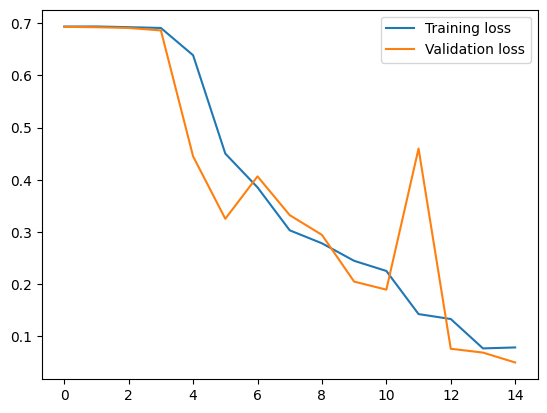

In [ ]:
import matplotlib.pyplot as plt
# Plot the training and validation losses
plt.plot(history.history['loss'],label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
#plt.title('loss')
plt.legend()
plt.show()

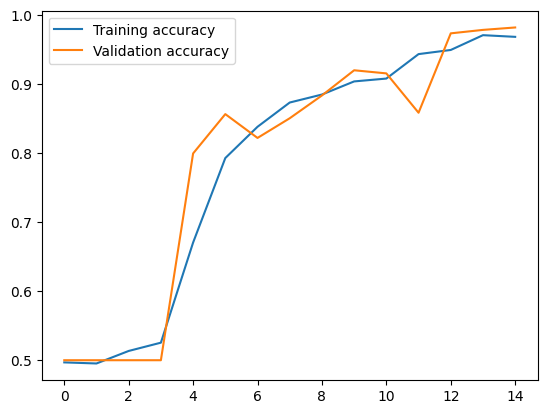

In [ ]:
# Both Validation and Training accuracy is shown here

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
#plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_set = val_datagen.flow_from_directory(
    "/content/splitted_data/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1000 images belonging to 2 classes.


In [ ]:
# CHECKING THE CONFUSION MATRIX

import numpy as np # linear algebra
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred ,axis =1)


32/32 [==============================] - 16s 498ms/step


In [ ]:
print('Classification Report')
target_names = ['aca','n']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

         aca       0.49      0.48      0.49       500
           n       0.49      0.51      0.50       500

    accuracy                           0.49      1000
   macro avg       0.49      0.49      0.49      1000
weighted avg       0.49      0.49      0.49      1000



In [ ]:
loss, acc = model.evaluate_generator(test_set, len(test_set))

print ("\n\n================================\n\n")
print ("Loss: {}".format(loss))
print ("Accuracy: {0:.2f} %".format(acc * 100))
print ("\n\n================================\n\n")

test_set.reset()

<ipython-input-31-9a3d6d22a8aa>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_set, len(test_set))






Loss: 0.05869288370013237
Accuracy: 97.80 %






In [ ]:
result = model.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

32/32 [==============================] - 16s 507ms/step - loss: 0.0587 - accuracy: 0.9780
test_loss, test accuracy [0.05869288370013237, 0.9779999852180481]


In [ ]:
preds = model.predict(test_set,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

32/32 [==============================] - 16s 498ms/step


In [ ]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Y_pred = model.predict_generator(validation_generator, nb_validation_samples //
#batch_size+1)
y_pred = np.argmax(preds, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))

Confusion Matrix
[[239 261]
 [247 253]]


In [ ]:
print('Classification Report')
target_names = [ 'Colon Benign','Colon Adenocarcinoma']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Classification Report
                      precision    recall  f1-score   support

        Colon Benign       0.49      0.48      0.48       500
Colon Adenocarcinoma       0.49      0.51      0.50       500

            accuracy                           0.49      1000
           macro avg       0.49      0.49      0.49      1000
        weighted avg       0.49      0.49      0.49      1000



In [ ]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

precision_score(test_set.classes, y_pred) , recall_score(test_set.classes, y_pred) ,  f1_score(test_set.classes, y_pred)

(0.49221789883268485, 0.506, 0.49901380670611445)

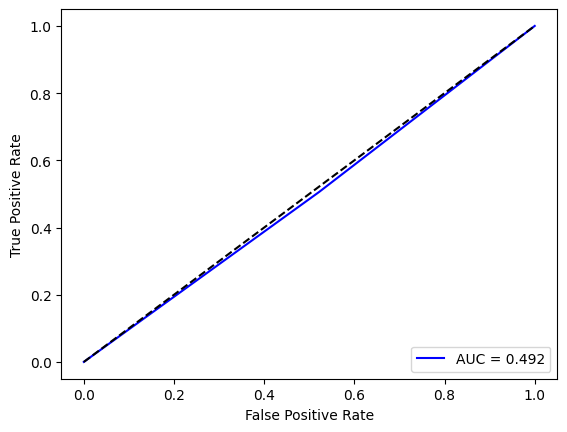

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(test_set.classes, y_pred)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
#plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.title('ROC curve')

plt.show()

<Axes: >

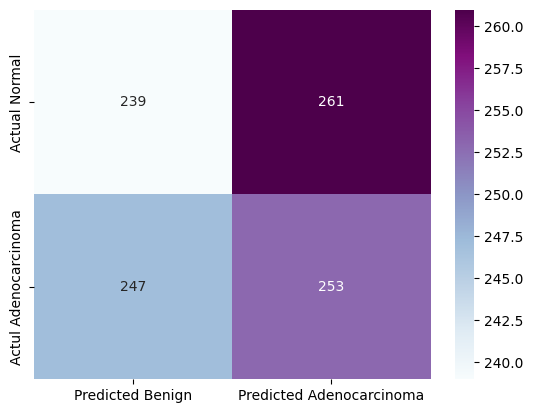

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix( y_true= test_set.classes, y_pred= y_pred, labels=[0, 1]), index=["Actual Normal", "Actul Adenocarcinoma"],columns=["Predicted Benign", "Predicted Adenocarcinoma"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d",cmap="BuPu")